# Clasificación de imágenes 2. 

En este caso trabajaremos con redes convolucionales, las cuales son el estado del arte en visión artificial. Recomiendo ejecutar este Notebook en Google Colab


In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

2.10.1


In [2]:
# additional imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

170498071/170498071 [==============================] - 119s 1us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [4]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [5]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [6]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Fit
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

Epoch 1/3
1563/1563 [==============================] - 277s 177ms/step - loss: 0.4209 - accuracy: 0.8572 - val_loss: 0.6285 - val_accuracy: 0.7993
Epoch 2/3
1563/1563 [==============================] - 286s 183ms/step - loss: 0.3537 - accuracy: 0.8788 - val_loss: 0.6074 - val_accuracy: 0.8117
Epoch 3/3
1563/1563 [==============================] - 323s 207ms/step - loss: 0.2983 - accuracy: 0.8959 - val_loss: 0.8207 - val_accuracy: 0.7817


In [11]:
# Fit with data augmentation
# Note: if you run this AFTER calling the previous model.fit(), it will CONTINUE training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=1)

1562/1562 [==============================] - 171s 109ms/step - loss: 0.6246 - accuracy: 0.7901 - val_loss: 0.5968 - val_accuracy: 0.8058


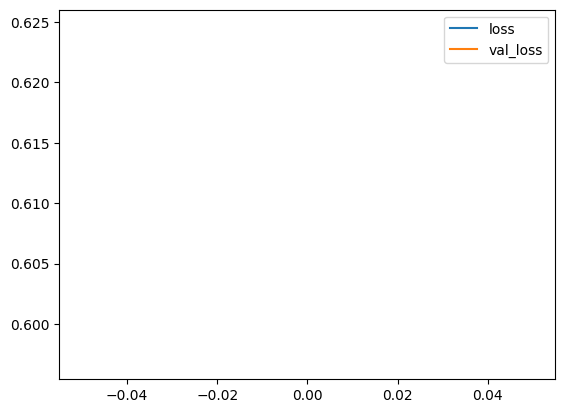

In [12]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))



In [ ]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [ ]:
# Now that the model is so large, it's useful to summarize it
model.summary()